<a href="https://colab.research.google.com/github/saravana3853/NLP/blob/main/Automatic_Ticket_Classification_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem Statement

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
import json
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# prompt: import drive

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
f=open("/content/drive/MyDrive/complaints-2021-05-14_08_16.json")

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [5]:
# Opening JSON file

# returns JSON object as
# a dictionary
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [6]:
# Inspect the dataframe to understand the given data.

df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [7]:
df.shape

(78313, 22)

In [8]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [9]:
len(df.columns)

22

In [10]:
columns=[i for i in df.columns.to_list() if not re.search('source',i)] + [i[len('_source.'):] for i in df.columns.to_list() if re.search('source',i)]

In [11]:
len(columns)

22

In [12]:
df.columns=columns

In [13]:
df['_index'].value_counts()

,count
_index,
complaint-public-v2,78313


In [14]:
df._type.value_counts()

,count
_type,
complaint,78313


In [15]:
df._score.value_counts()

,count
_score,
0.0,78313


In [16]:
df['tags'].isnull().sum()

67413

In [17]:
df['zip_code'].isnull().sum()

6757

In [18]:
df['complaint_what_happened'].isnull().sum()

0

In [19]:
df['company'].value_counts()

,count
company,
JPMORGAN CHASE & CO.,78313


In [20]:
df[df['complaint_what_happened'].str.strip() == '']['complaint_what_happened'].shape

(57241,)

In [21]:
df['company_public_response'].value_counts()

,count
company_public_response,
Company has responded to the consumer and the CFPB and chooses not to provide a public response,2
Company believes complaint relates to a discontinued policy or procedure,1
Company chooses not to provide a public response,1


In [22]:
df['company_public_response'].isnull().sum()

78309

In [23]:
df['product'].value_counts()

,count
product,
Mortgage,22725
Checking or savings account,12147
Credit card or prepaid card,10797
Credit card,10373
Bank account or service,9816
"Credit reporting, credit repair services, or other personal consumer reports",4310
Debt collection,3201
"Money transfer, virtual currency, or money service",1500
Consumer Loan,1029


In [24]:
df['company_response'].value_counts()

,count
company_response,
Closed with explanation,60230
Closed with monetary relief,10129
Closed with non-monetary relief,4383
Closed without relief,2009
Closed with relief,813
Closed,628
In progress,119
Untimely response,2


In [25]:
#Assign nan in place of blanks in the complaints column
df['complaint_what_happened'] = df['complaint_what_happened'].replace(r'^\s*$', np.nan, regex=True)

In [26]:
df['complaint_what_happened'].isnull().sum()

57241

In [27]:
#Remove all rows where complaints column is nan
df=df.dropna(subset=['complaint_what_happened'])

In [28]:
df['complaint_what_happened'].isna().sum()

0

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [29]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [30]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [31]:
from nltk import word_tokenize,sent_tokenize
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [32]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [33]:
import spacy
nlp = spacy.load("en_core_web_sm",disable=['ner','parser'])


In [34]:
# Write your function here to clean the text and remove all the unnecessary elements.
def clean_text(text):
  text = text.lower() # lower text
  tokens=word_tokenize(text) # tokenizing
  processed_text=[i for i in tokens if i not in stop_words] # stop word removal
  processed_text=[i for i in processed_text if i not in string.punctuation] # punctuation removal
  processed_tokens=nlp(" ".join(processed_text))
  lemmatized=[i.lemma_ for i in processed_tokens if i.pos_ in ['NOUN','PRON']] # lemmatizing only NN tags
  return lemmatized

In [35]:
#Write your function to Lemmatize the texts
df['complaint_what_happened_lemmatized'] = df['complaint_what_happened'].apply(lambda x: clean_text(x))

In [36]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints
df_clean=df[['complaint_what_happened','complaint_what_happened_lemmatized']]

In [37]:
df_clean.head()

,complaint_what_happened,complaint_what_happened_lemmatized
1,Good morning my name is XXXX XXXX and I apprec...,"[morning, name, chase, debt, verification, sta..."
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,"[agent, upgrade, anniversary, date, agent, inf..."
10,Chase Card was reported on XX/XX/2019. However...,"[chase, card, application, identity, consent, ..."
11,"On XX/XX/2018, while trying to book a XXXX XX...","[book, ticket, offer, ticket, reward, card, in..."
14,my grand son give me check for {$1600.00} i de...,"[son, check, deposit, chase, account, fund, ac..."


In [38]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,complaint_what_happened,complaint_what_happened_lemmatized
1,Good morning my name is XXXX XXXX and I apprec...,"[morning, name, chase, debt, verification, sta..."
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,"[agent, upgrade, anniversary, date, agent, inf..."
10,Chase Card was reported on XX/XX/2019. However...,"[chase, card, application, identity, consent, ..."
11,"On XX/XX/2018, while trying to book a XXXX XX...","[book, ticket, offer, ticket, reward, card, in..."
14,my grand son give me check for {$1600.00} i de...,"[son, check, deposit, chase, account, fund, ac..."
...,...,...
78303,After being a Chase Card customer for well ove...,"[chase, card, customer, decade, solicitation, ..."
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...","[credit, card, provider, claim, protection, sc..."
78310,I am not familiar with XXXX pay and did not un...,"[pay, risk, consumer, chase, bank, app, chase,..."
78311,I have had flawless credit for 30 yrs. I've ha...,"[credit, yrs, chase, credit, card, freedom, pr..."


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




In [39]:
# Write your code here to visualise the data according to the 'Complaint' character length
df_clean['complaint_length']=df_clean['complaint_what_happened'].str.len()

<Axes: xlabel='complaint_length', ylabel='Count'>

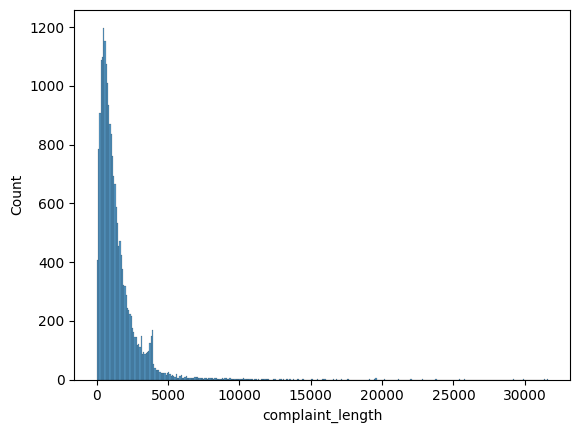

In [40]:
import seaborn as sns
sns.histplot(df_clean['complaint_length'])

#### Find the top 40 words by frequency among all the articles after processing the text.

In [41]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
df_clean['complaint_clean'] = df_clean['complaint_what_happened_lemmatized'].apply(lambda x: " ".join(x))

In [42]:
!pip install wordcloud

In [43]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [44]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white', max_words=40,
                min_font_size = 10).generate(" ".join(df_clean['complaint_clean']))

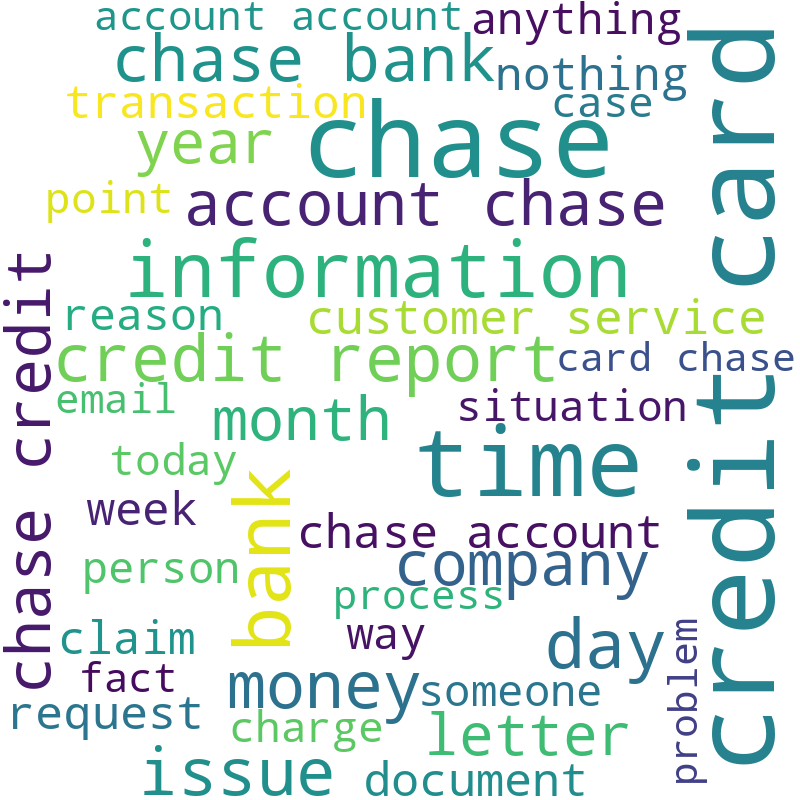

In [45]:
wordcloud.to_image()

In [46]:
df_clean['complaint_clean']

,complaint_clean
1,morning name chase debt verification statement...
2,agent upgrade anniversary date agent informati...
10,chase card application identity consent servic...
11,book ticket offer ticket reward card informati...
14,son check deposit chase account fund account m...
...,...
78303,chase card customer decade solicitation credit...
78309,credit card provider claim protection school t...
78310,pay risk consumer chase bank app chase year tr...
78311,credit yrs chase credit card freedom problem b...


#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [47]:
from sklearn.feature_extraction.text import CountVectorizer

In [48]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean).
unigrams_cv = CountVectorizer(ngram_range=(1,1),stop_words='english')
unigrams=unigrams_cv.fit_transform(df_clean['complaint_clean'])

In [49]:
unigrams_cv.get_feature_names_out().shape

(12442,)

In [50]:
unigram_df=pd.DataFrame(unigrams.toarray(),columns=unigrams_cv.get_feature_names_out())

In [51]:
unigram_df.sum().sort_values(ascending=False)[:10]

,0
chase,60624
account,42054
credit,32780
card,30004
payment,21215
time,15895
bank,15789
day,12968
charge,12274
money,11787


In [52]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean).
bigrams_cv = CountVectorizer(ngram_range=(2,2),stop_words='english')
bigrams=bigrams_cv.fit_transform(df_clean['complaint_clean'])

In [53]:
#Print the top 10 words in the bigram frequency
bigrams_df=pd.DataFrame(bigrams.toarray(),columns=bigrams_cv.get_feature_names_out())

In [54]:
bigrams_df.head()

,00 account,00 amendment,00 credit,00 customer,00 fee,00 matter,000 00,01 2008,01 internet,0111 credit,...,zone risk,zone term,zone thank,zone time,zone wrong,zone xxxx,zone year,zoo family,zoom claim,zoom paper
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [55]:
bigrams_df.sum().sort_values(ascending=False)[:10]

,0
credit card,12820
credit report,3768
chase bank,3647
account chase,3447
chase credit,3424
customer service,2969
chase account,2899
account account,2381
card chase,2099
debit card,1981


In [56]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean).
trigrams_cv = CountVectorizer(ngram_range=(3,3),stop_words='english')
trigrams=trigrams_cv.fit_transform(df_clean['complaint_clean'])

In [57]:
#Print the top 10 words in the trigram frequency
trigrams_df=pd.DataFrame(trigrams.toarray(),columns=trigrams_cv.get_feature_names_out())

In [58]:
trigrams_df.head()

,00 account 31,00 amendment form,00 credit amend,00 customer service,00 fee statement,00 matter document,000 00 fee,01 2008 ca,01 internet delinquent,0111 credit reporting,...,zone reservation sum,zone risk act,zone term condition,zone thank loyalty,zone time representative,zone wrong complaint,zone year chase,zoo family line,zoom claim fund,zoom paper mark
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [59]:
trigrams_df.sum().sort_values(ascending=False)[:10]

,0
chase credit card,2304
credit card account,1024
credit card company,1007
credit card chase,973
chase customer service,635
credit card credit,585
inquiry credit report,505
card credit card,462
charge credit card,416
account credit card,401


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [60]:
df_clean['complaint_clean'].str.contains('xxxx').sum()

815

In [61]:
df_clean['complaint_clean'] = df_clean['complaint_clean'].str.replace('xxxx','')

In [62]:
df_clean['complaint_clean'].str.contains('xxxx').sum()

0

In [63]:
#df_clean['complaint_clean'] = df_clean['complaint_clean'].str.replace('chase','')

In [64]:
#All masked texts has been removed
df_clean

,complaint_what_happened,complaint_what_happened_lemmatized,complaint_length,complaint_clean
1,Good morning my name is XXXX XXXX and I apprec...,"[morning, name, chase, debt, verification, sta...",486,morning name chase debt verification statement...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,"[agent, upgrade, anniversary, date, agent, inf...",355,agent upgrade anniversary date agent informati...
10,Chase Card was reported on XX/XX/2019. However...,"[chase, card, application, identity, consent, ...",224,chase card application identity consent servic...
11,"On XX/XX/2018, while trying to book a XXXX XX...","[book, ticket, offer, ticket, reward, card, in...",1502,book ticket offer ticket reward card informati...
14,my grand son give me check for {$1600.00} i de...,"[son, check, deposit, chase, account, fund, ac...",477,son check deposit chase account fund account m...
...,...,...,...,...
78303,After being a Chase Card customer for well ove...,"[chase, card, customer, decade, solicitation, ...",679,chase card customer decade solicitation credit...
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...","[credit, card, provider, claim, protection, sc...",2114,credit card provider claim protection school t...
78310,I am not familiar with XXXX pay and did not un...,"[pay, risk, consumer, chase, bank, app, chase,...",2319,pay risk consumer chase bank app chase year tr...
78311,I have had flawless credit for 30 yrs. I've ha...,"[credit, yrs, chase, credit, card, freedom, pr...",2171,credit yrs chase credit card freedom problem b...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [65]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [66]:
#Write your code here to initialise the TfidfVectorizer
tfidf = TfidfVectorizer(max_df=0.95,min_df=2,stop_words='english')

In [67]:
features_X=tfidf.fit_transform(df_clean['complaint_clean'])

In [68]:
features_X.shape

(21072, 6406)

In [69]:
features_X[1]

<1x6406 sparse matrix of type '<class 'numpy.float64'>'
	with 8 stored elements in Compressed Sparse Row format>

In [70]:
dtm=features_X.toarray()

In [71]:
tf_df=pd.DataFrame(features_X.toarray(),columns=tfidf.get_feature_names_out())

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [72]:
tf_df.head()

,00,0111,0f,10,1000,1099a,10day,10k,10min,10year,...,youth,yr,yrs,ys,zero,zeroed,zip,zombie,zone,zoom
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.237637,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints
* Correct the labels if needed
* Map the clusters to topics/cluster names

In [73]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [74]:
#Load your nmf_model with the n_components i.e 5
num_topics = 6 #write the value you want to test out

#keep the random_state =40
nmf_model = NMF(n_components=num_topics,random_state=40) #write your code here

In [75]:
W=nmf_model.fit_transform(tf_df)


In [76]:
H=nmf_model.components_

In [77]:
nmf_model.n_features_in_

6406

In [78]:
nmf_model.get_feature_names_out()

array(['nmf0', 'nmf1', 'nmf2', 'nmf3', 'nmf4', 'nmf5'], dtype=object)

In [79]:
H.shape # topics

(6, 6406)

In [80]:
W.shape # documents

(21072, 6)

In [81]:
df_topic_term=pd.DataFrame(H,columns=tfidf.get_feature_names_out())

In [82]:
df_doc_topics=pd.DataFrame(W,columns=['Topic_'+str(i) for i in range(num_topics)])

In [83]:
topics_names=df_doc_topics.idxmax(axis=1)

In [84]:
df_topic_term

,00,0111,0f,10,1000,1099a,10day,10k,10min,10year,...,youth,yr,yrs,ys,zero,zeroed,zip,zombie,zone,zoom
0,0.000809,0.000000,0.002454,0.004701,0.000000,0.000188,0.000000,0.000031,0.000339,0.002051,...,0.000795,0.000852,0.000000,0.000000,0.001689,0.002635,0.000000,0.000086,0.000470,0.000252
1,0.000000,0.000000,0.000000,0.000541,0.000000,0.000000,0.000000,0.002794,0.000000,0.000259,...,0.000000,0.001724,0.003591,0.000569,0.000920,0.000000,0.004410,0.000000,0.000000,0.000178
2,0.001884,0.000000,0.000000,0.000000,0.000000,0.000000,0.002606,0.000000,0.000127,0.000000,...,0.000000,0.003242,0.006633,0.000263,0.000023,0.000000,0.004076,0.000000,0.004130,0.000000
3,0.000000,0.000266,0.000000,0.000000,0.000000,0.000386,0.000625,0.000000,0.000327,0.000023,...,0.000078,0.000000,0.001867,0.000214,0.000000,0.000637,0.002116,0.001623,0.000000,0.000000
4,0.000000,0.000001,0.000000,0.001624,0.000000,0.001448,0.000000,0.001616,0.000361,0.000000,...,0.000013,0.012464,0.009866,0.000000,0.000000,0.000000,0.002763,0.000846,0.002693,0.000000
5,0.001126,0.000005,0.000000,0.000212,0.003394,0.000000,0.000000,0.000000,0.000301,0.000000,...,0.000000,0.000185,0.000000,0.000160,0.000000,0.001956,0.005336,0.000163,0.003910,0.000184


In [85]:
df_topic_term.idxmax(axis=1)

,0
0,account
1,card
2,payment
3,inquiry
4,loan
5,charge


In [86]:
topics={}
for i in range(len(df_topic_term.index)):
  indexes=df_topic_term[df_topic_term.index==i].to_numpy().argsort()[0][-15:]
  topics['Topic_'+str(i)]=[df_topic_term.columns[j] for j in indexes[::-1]]

In [87]:
topic_df=pd.DataFrame(index=topics.keys(),columns=range(15),data=topics.values())

In [88]:
#Print the Top15 words for each of the topics

In [89]:
topic_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Topic_0,account,check,money,chase,bank,fund,deposit,day,branch,number,business,transfer,transaction,fee,customer
Topic_1,card,credit,chase,balance,account,year,limit,score,purchase,point,month,service,reason,application,time
Topic_2,payment,balance,fee,month,statement,day,auto,time,date,credit,chase,pay,error,mortgage,year
Topic_3,inquiry,report,credit,company,reporting,information,debt,identity,score,bureau,theft,account,letter,file,agency
Topic_4,loan,mortgage,chase,modification,home,year,property,rate,letter,document,time,foreclosure,sale,debt,information
Topic_5,charge,dispute,transaction,chase,merchant,claim,fraud,fee,purchase,service,company,email,day,time,letter


In [90]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4

#1.Credit card / Prepaid card
#2.Bank account services
#3.Theft/Dispute reporting
#4.Mortgages/loans
#5.Others

generated_topics=topic_df[[0,1]]

In [91]:
generated_topics.columns=['word_1','word_2']

In [92]:
generated_topics['generated_topics']=generated_topics.apply(lambda x: " ".join((x['word_1'],x['word_2'])),axis=1)

In [93]:
topic_mapper={'account check':'Bank Account Services','card credit':'Credit Card/Prepayment Card','payment balance':'Bank Account Services','inquiry report':'Cibil Queries','loan mortgage':'Mortgages/Loans','charge dispute':'Theft/Dispute Reporting'}

In [94]:
generated_topics['final_topics']=generated_topics['generated_topics'].map(lambda x:topic_mapper.get(x))

In [95]:
generated_topics

,word_1,word_2,generated_topics,final_topics
Topic_0,account,check,account check,Bank Account Services
Topic_1,card,credit,card credit,Credit Card/Prepayment Card
Topic_2,payment,balance,payment balance,Bank Account Services
Topic_3,inquiry,report,inquiry report,Cibil Queries
Topic_4,loan,mortgage,loan mortgage,Mortgages/Loans
Topic_5,charge,dispute,charge dispute,Theft/Dispute Reporting


In [96]:
#Assign the best topic to each of the cmplaints in Topic Column
df_clean.reset_index(inplace=True,drop=True)

In [97]:
df_clean['Topic']=topics_names

In [98]:
df_clean

,complaint_what_happened,complaint_what_happened_lemmatized,complaint_length,complaint_clean,Topic
0,Good morning my name is XXXX XXXX and I apprec...,"[morning, name, chase, debt, verification, sta...",486,morning name chase debt verification statement...,Topic_4
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,"[agent, upgrade, anniversary, date, agent, inf...",355,agent upgrade anniversary date agent informati...,Topic_0
2,Chase Card was reported on XX/XX/2019. However...,"[chase, card, application, identity, consent, ...",224,chase card application identity consent servic...,Topic_1
3,"On XX/XX/2018, while trying to book a XXXX XX...","[book, ticket, offer, ticket, reward, card, in...",1502,book ticket offer ticket reward card informati...,Topic_3
4,my grand son give me check for {$1600.00} i de...,"[son, check, deposit, chase, account, fund, ac...",477,son check deposit chase account fund account m...,Topic_0
...,...,...,...,...,...
21067,After being a Chase Card customer for well ove...,"[chase, card, customer, decade, solicitation, ...",679,chase card customer decade solicitation credit...,Topic_1
21068,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...","[credit, card, provider, claim, protection, sc...",2114,credit card provider claim protection school t...,Topic_5
21069,I am not familiar with XXXX pay and did not un...,"[pay, risk, consumer, chase, bank, app, chase,...",2319,pay risk consumer chase bank app chase year tr...,Topic_3
21070,I have had flawless credit for 30 yrs. I've ha...,"[credit, yrs, chase, credit, card, freedom, pr...",2171,credit yrs chase credit card freedom problem b...,Topic_2


In [99]:
df_clean['Topic'][0]

'Topic_4'

In [100]:
generated_topics[generated_topics.index==df_clean['Topic'][0]]['final_topics'][0]

'Mortgages/Loans'

In [101]:
df_clean['Final Topics']=df_clean['Topic'].map(lambda x:generated_topics[generated_topics.index==x]['final_topics'][0])

In [102]:
df_clean

,complaint_what_happened,complaint_what_happened_lemmatized,complaint_length,complaint_clean,Topic,Final Topics
0,Good morning my name is XXXX XXXX and I apprec...,"[morning, name, chase, debt, verification, sta...",486,morning name chase debt verification statement...,Topic_4,Mortgages/Loans
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,"[agent, upgrade, anniversary, date, agent, inf...",355,agent upgrade anniversary date agent informati...,Topic_0,Bank Account Services
2,Chase Card was reported on XX/XX/2019. However...,"[chase, card, application, identity, consent, ...",224,chase card application identity consent servic...,Topic_1,Credit Card/Prepayment Card
3,"On XX/XX/2018, while trying to book a XXXX XX...","[book, ticket, offer, ticket, reward, card, in...",1502,book ticket offer ticket reward card informati...,Topic_3,Cibil Queries
4,my grand son give me check for {$1600.00} i de...,"[son, check, deposit, chase, account, fund, ac...",477,son check deposit chase account fund account m...,Topic_0,Bank Account Services
...,...,...,...,...,...,...
21067,After being a Chase Card customer for well ove...,"[chase, card, customer, decade, solicitation, ...",679,chase card customer decade solicitation credit...,Topic_1,Credit Card/Prepayment Card
21068,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...","[credit, card, provider, claim, protection, sc...",2114,credit card provider claim protection school t...,Topic_5,Theft/Dispute Reporting
21069,I am not familiar with XXXX pay and did not un...,"[pay, risk, consumer, chase, bank, app, chase,...",2319,pay risk consumer chase bank app chase year tr...,Topic_3,Cibil Queries
21070,I have had flawless credit for 30 yrs. I've ha...,"[credit, yrs, chase, credit, card, freedom, pr...",2171,credit yrs chase credit card freedom problem b...,Topic_2,Bank Account Services


In [103]:
df_clean.head()

,complaint_what_happened,complaint_what_happened_lemmatized,complaint_length,complaint_clean,Topic,Final Topics
0,Good morning my name is XXXX XXXX and I apprec...,"[morning, name, chase, debt, verification, sta...",486,morning name chase debt verification statement...,Topic_4,Mortgages/Loans
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,"[agent, upgrade, anniversary, date, agent, inf...",355,agent upgrade anniversary date agent informati...,Topic_0,Bank Account Services
2,Chase Card was reported on XX/XX/2019. However...,"[chase, card, application, identity, consent, ...",224,chase card application identity consent servic...,Topic_1,Credit Card/Prepayment Card
3,"On XX/XX/2018, while trying to book a XXXX XX...","[book, ticket, offer, ticket, reward, card, in...",1502,book ticket offer ticket reward card informati...,Topic_3,Cibil Queries
4,my grand son give me check for {$1600.00} i de...,"[son, check, deposit, chase, account, fund, ac...",477,son check deposit chase account fund account m...,Topic_0,Bank Account Services


In [104]:
#Print the first 5 Complaint for each of the Topics
df_clean_grouped=df_clean.groupby('Final Topics').head(5)
df_clean[['complaint_what_happened','Final Topics']].sort_values('Final Topics')
df_clean_grouped[['complaint_what_happened','Final Topics']].sort_values('Final Topics')

,complaint_what_happened,Final Topics
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Bank Account Services
4,my grand son give me check for {$1600.00} i de...,Bank Account Services
6,With out notice J.P. Morgan Chase restricted m...,Bank Account Services
7,"During the summer months, I experience a decli...",Bank Account Services
10,mishandling of this account by Chase auto and ...,Bank Account Services
34,UNKNOWN INQUIRE REPORTED ON MY CREDIT BUREAU S...,Cibil Queries
3,"On XX/XX/2018, while trying to book a XXXX XX...",Cibil Queries
5,Can you please remove inquiry,Cibil Queries
9,I have a Chase credit card which is incorrectl...,Cibil Queries
11,I have reached out to XXXX several times in at...,Cibil Queries


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [105]:
df_clean

,complaint_what_happened,complaint_what_happened_lemmatized,complaint_length,complaint_clean,Topic,Final Topics
0,Good morning my name is XXXX XXXX and I apprec...,"[morning, name, chase, debt, verification, sta...",486,morning name chase debt verification statement...,Topic_4,Mortgages/Loans
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,"[agent, upgrade, anniversary, date, agent, inf...",355,agent upgrade anniversary date agent informati...,Topic_0,Bank Account Services
2,Chase Card was reported on XX/XX/2019. However...,"[chase, card, application, identity, consent, ...",224,chase card application identity consent servic...,Topic_1,Credit Card/Prepayment Card
3,"On XX/XX/2018, while trying to book a XXXX XX...","[book, ticket, offer, ticket, reward, card, in...",1502,book ticket offer ticket reward card informati...,Topic_3,Cibil Queries
4,my grand son give me check for {$1600.00} i de...,"[son, check, deposit, chase, account, fund, ac...",477,son check deposit chase account fund account m...,Topic_0,Bank Account Services
...,...,...,...,...,...,...
21067,After being a Chase Card customer for well ove...,"[chase, card, customer, decade, solicitation, ...",679,chase card customer decade solicitation credit...,Topic_1,Credit Card/Prepayment Card
21068,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...","[credit, card, provider, claim, protection, sc...",2114,credit card provider claim protection school t...,Topic_5,Theft/Dispute Reporting
21069,I am not familiar with XXXX pay and did not un...,"[pay, risk, consumer, chase, bank, app, chase,...",2319,pay risk consumer chase bank app chase year tr...,Topic_3,Cibil Queries
21070,I have had flawless credit for 30 yrs. I've ha...,"[credit, yrs, chase, credit, card, freedom, pr...",2171,credit yrs chase credit card freedom problem b...,Topic_2,Bank Account Services


--------------------------------------------------------------------------------

### Topic Modeling with LDA

In [106]:
!pip install gensim

In [107]:
from gensim.models import LdaModel
from gensim.corpora import Dictionary
from gensim.utils import simple_preprocess

In [108]:
dictionary=Dictionary(df_clean['complaint_clean'].apply(lambda x:simple_preprocess(x)))

In [109]:
corpus=[dictionary.doc2bow(i) for i in df_clean['complaint_clean'].apply(lambda x:simple_preprocess(x))]

In [110]:
lda_model=LdaModel(corpus=corpus,id2word=dictionary,num_topics=6)

In [111]:
for i in lda_model.print_topics():
  print(i)

(0, '0.061*"chase" + 0.037*"mortgage" + 0.032*"loan" + 0.018*"year" + 0.017*"time" + 0.016*"rate" + 0.015*"home" + 0.015*"we" + 0.014*"payment" + 0.012*"month"')
(1, '0.073*"chase" + 0.073*"account" + 0.065*"payment" + 0.053*"credit" + 0.028*"card" + 0.019*"time" + 0.017*"balance" + 0.015*"day" + 0.015*"month" + 0.015*"fee"')
(2, '0.062*"chase" + 0.025*"dispute" + 0.017*"time" + 0.017*"letter" + 0.016*"merchant" + 0.016*"day" + 0.016*"call" + 0.015*"car" + 0.013*"phone" + 0.012*"claim"')
(3, '0.128*"card" + 0.076*"credit" + 0.061*"chase" + 0.054*"charge" + 0.019*"account" + 0.016*"purchase" + 0.015*"fee" + 0.015*"transaction" + 0.015*"interest" + 0.012*"balance"')
(4, '0.042*"credit" + 0.036*"loan" + 0.031*"chase" + 0.024*"payment" + 0.023*"report" + 0.023*"debt" + 0.017*"mortgage" + 0.014*"letter" + 0.013*"modification" + 0.013*"information"')
(5, '0.077*"account" + 0.051*"chase" + 0.038*"money" + 0.036*"bank" + 0.035*"check" + 0.026*"fund" + 0.021*"day" + 0.019*"transaction" + 0.015*

In [112]:
!pip install pyLDAvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 398.9/398.9 kB 25.9 MB/s eta 0:00:00


In [201]:
from gensim.models import CoherenceModel

In [205]:
coherence_model=CoherenceModel(model=lda_model,texts=df_clean['complaint_clean'].apply(lambda x:simple_preprocess(x)),dictionary=dictionary,coherence='c_v')

In [206]:
coherence_model.get_coherence()

0.4088582707947832

In [113]:
import pyLDAvis
import pyLDAvis.gensim_models

In [114]:
pyLDAvis.enable_notebook()

In [115]:
pyLDAvis.gensim_models.prepare(lda_model,corpus,dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.117836 -0.110946       1        1  23.831990
1     -0.051724  0.032510       2        1  19.946246
3     -0.102874  0.128635       3        1  15.935282
2     -0.016281 -0.016631       4        1  13.752636
0      0.097849 -0.085765       5        1  13.673950
4      0.190866  0.052197       6        1  12.859895, topic_info=          Term          Freq         Total Category  logprob  loglift
24        card  29812.000000  29812.000000  Default  30.0000  30.0000
25      credit  32024.000000  32024.000000  Default  29.0000  29.0000
0      account  41215.000000  41215.000000  Default  28.0000  28.0000
226     charge  12019.000000  12019.000000  Default  27.0000  27.0000
79     payment  21388.000000  21388.000000  Default  26.0000  26.0000
..         ...           ...           ...      ...      ...      ...
41     request    857.614765   4172.908401   Topic6  -5.0983   0.4688
334       sale    759.822926   2401.443157   Topic6  -5.2193   0.9003
2         bank    920.180178  15877.297941   Topic6  -5.0278  -0.7970
238  complaint    802.536869   4234.309459   Topic6  -5.1646   0.3879
0      account    862.315306  41215.725566   Topic6  -5.0928  -1.8159

[526 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
266       1  0.572008  access
266       2  0.296851  access
266       3  0.065614  access
266       4  0.012170  access
266       5  0.041273  access
...     ...       ...     ...
114       2  0.277481    year
114       3  0.097096    year
114       4  0.023086    year
114       5  0.303508    year
114       6  0.180385    year

[1471 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 2, 4, 3, 1, 5])

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [116]:
#Create the dictionary again of Topic names and Topics

Topic_names = {   }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Final Topics']
df_clean.drop('Final Topics',axis=1,inplace=True)

In [117]:
df_clean.shape

(21072, 5)

In [118]:
df_clean

,complaint_what_happened,complaint_what_happened_lemmatized,complaint_length,complaint_clean,Topic
0,Good morning my name is XXXX XXXX and I apprec...,"[morning, name, chase, debt, verification, sta...",486,morning name chase debt verification statement...,Mortgages/Loans
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,"[agent, upgrade, anniversary, date, agent, inf...",355,agent upgrade anniversary date agent informati...,Bank Account Services
2,Chase Card was reported on XX/XX/2019. However...,"[chase, card, application, identity, consent, ...",224,chase card application identity consent servic...,Credit Card/Prepayment Card
3,"On XX/XX/2018, while trying to book a XXXX XX...","[book, ticket, offer, ticket, reward, card, in...",1502,book ticket offer ticket reward card informati...,Cibil Queries
4,my grand son give me check for {$1600.00} i de...,"[son, check, deposit, chase, account, fund, ac...",477,son check deposit chase account fund account m...,Bank Account Services
...,...,...,...,...,...
21067,After being a Chase Card customer for well ove...,"[chase, card, customer, decade, solicitation, ...",679,chase card customer decade solicitation credit...,Credit Card/Prepayment Card
21068,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...","[credit, card, provider, claim, protection, sc...",2114,credit card provider claim protection school t...,Theft/Dispute Reporting
21069,I am not familiar with XXXX pay and did not un...,"[pay, risk, consumer, chase, bank, app, chase,...",2319,pay risk consumer chase bank app chase year tr...,Cibil Queries
21070,I have had flawless credit for 30 yrs. I've ha...,"[credit, yrs, chase, credit, card, freedom, pr...",2171,credit yrs chase credit card freedom problem b...,Bank Account Services


In [119]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=df_clean[['complaint_what_happened','Topic']]

In [120]:
training_data.shape

(21072, 2)

In [121]:
training_data.head(10)

,complaint_what_happened,Topic
0,Good morning my name is XXXX XXXX and I apprec...,Mortgages/Loans
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Bank Account Services
2,Chase Card was reported on XX/XX/2019. However...,Credit Card/Prepayment Card
3,"On XX/XX/2018, while trying to book a XXXX XX...",Cibil Queries
4,my grand son give me check for {$1600.00} i de...,Bank Account Services
5,Can you please remove inquiry,Cibil Queries
6,With out notice J.P. Morgan Chase restricted m...,Bank Account Services
7,"During the summer months, I experience a decli...",Bank Account Services
8,"On XXXX XX/XX/2019, I made a {$300.00} payment...",Theft/Dispute Reporting
9,I have a Chase credit card which is incorrectl...,Cibil Queries


In [122]:
training_data['complaint_what_happened']=training_data['complaint_what_happened'].apply(lambda x:" ".join(clean_text(x)))

####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [123]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [124]:
#Write your code to get the Vector count

vectorizer=CountVectorizer(max_df=.95,min_df=2,max_features=5000,stop_words='english')
vector_count=vectorizer.fit_transform(training_data['complaint_what_happened'])



#Write your code here to transform the word vector to tf-idf
tfidf_vector=TfidfTransformer().fit_transform(vector_count)


You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [125]:
training_data['complaint_what_happened']

,complaint_what_happened
0,morning name chase debt verification statement...
1,agent upgrade anniversary date agent informati...
2,chase card application identity consent servic...
3,book ticket offer ticket reward card informati...
4,son check deposit chase account fund account m...
...,...
21067,chase card customer decade solicitation credit...
21068,credit card provider claim protection school t...
21069,pay risk consumer chase bank app chase year tr...
21070,credit yrs chase credit card freedom problem b...


In [126]:
tfidf_vector.toarray().shape

(21072, 5000)

In [127]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import train_test_split

In [128]:
training_data['Topic'].to_numpy().shape

(21072,)

In [129]:
feature_vectors=pd.DataFrame(tfidf_vector.toarray(),columns=vectorizer.get_feature_names_out())

In [130]:
feature_vectors.head()

,00,0111,10,1000,1099a,10day,10k,10min,10year,12th,...,yesterday,yield,youth,yr,yrs,zero,zeroed,zip,zombie,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.237635,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Logistic Regression

In [160]:


from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
training_data['Topic_encoded'] = le.fit_transform(training_data['Topic'])

In [171]:
le.classes_

array(['Bank Account Services', 'Cibil Queries',
       'Credit Card/Prepayment Card', 'Mortgages/Loans',
       'Theft/Dispute Reporting'], dtype=object)

In [162]:
training_data['Topic_encoded'].value_counts()

,count
Topic_encoded,
0,7515
2,4131
3,3838
4,3595
1,1993


In [163]:
# Write your code here to build any 3 models and evaluate them using the required metrics
X_train,X_test,y_train,y_test=train_test_split(feature_vectors,training_data['Topic_encoded'].to_numpy(),test_size=0.3,random_state=42)
lr=LogisticRegression()
lr.fit(X_train,y_train)

LogisticRegression()

In [164]:
y_train.shape

(14750,)

In [165]:
y_pred=lr.predict(X_train)
print(confusion_matrix(y_train,y_pred))
print(classification_report(y_train,y_pred))

[[5147    4   38   22   28]
 [  30 1297   13   14    6]
 [  52    2 2824    4   13]
 [  57    5    8 2647    2]
 [  65    1    6    7 2458]]
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      5239
           1       0.99      0.95      0.97      1360
           2       0.98      0.98      0.98      2895
           3       0.98      0.97      0.98      2719
           4       0.98      0.97      0.97      2537

    accuracy                           0.97     14750
   macro avg       0.98      0.97      0.97     14750
weighted avg       0.97      0.97      0.97     14750



In [166]:
y_pred_test=lr.predict(X_test)
print(confusion_matrix(y_test,y_pred_test))
print(classification_report(y_test,y_pred_test))

[[2187    9   25   33   22]
 [  26  558   18   25    6]
 [  40    4 1156    7   29]
 [  53    4    8 1046    8]
 [  64    1   14   11  968]]
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      2276
           1       0.97      0.88      0.92       633
           2       0.95      0.94      0.94      1236
           3       0.93      0.93      0.93      1119
           4       0.94      0.91      0.93      1058

    accuracy                           0.94      6322
   macro avg       0.94      0.93      0.93      6322
weighted avg       0.94      0.94      0.94      6322



In [172]:
features_lr=pd.DataFrame(columns=range(15))
features=[]
for i in range(lr.coef_.shape[0]):
  features.append(feature_vectors.columns[lr.coef_[i].argsort()[-15:][::-1]])
features_lr=pd.DataFrame(features,columns=range(15),index=le.classes_)

In [173]:
training_data[['Topic','Topic_encoded']].value_counts()

,,count
Topic,Topic_encoded,
Bank Account Services,0,7515
Credit Card/Prepayment Card,2,4131
Mortgages/Loans,3,3838
Theft/Dispute Reporting,4,3595
Cibil Queries,1,1993


In [174]:
features_lr

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Bank Account Services,payment,account,check,money,fund,deposit,bank,branch,saving,day,transfer,balance,wire,banking,statement
Cibil Queries,report,inquiry,credit,reporting,company,identity,bureau,theft,information,creditor,inquire,fcra,file,debt,police
Credit Card/Prepayment Card,card,credit,point,balance,limit,amazon,mile,reward,bonus,use,benefit,year,line,offer,chase
Mortgages/Loans,loan,mortgage,home,property,modification,rate,chase,house,title,document,year,foreclosure,debt,sale,attorney
Theft/Dispute Reporting,charge,dispute,transaction,merchant,claim,fee,fraud,refund,email,purchase,service,flight,ticket,item,vendor


### Decision Tree Classifier

In [175]:
from sklearn.tree import DecisionTreeClassifier

In [176]:
from sklearn.tree import plot_tree
from matplotlib import pyplot

In [177]:
dtc=DecisionTreeClassifier(min_samples_leaf=2,max_depth=25,max_leaf_nodes=10)

In [178]:
dtc.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=25, max_leaf_nodes=10, min_samples_leaf=2)

In [179]:
y_pred=dtc.predict(X_train)
print(confusion_matrix(y_train,y_pred))
print(classification_report(y_train,y_pred))

[[3135  219  566 1075  244]
 [ 103  625  295  282   55]
 [  99    7 2343  181  265]
 [ 184   32   35 2440   28]
 [ 238   23  216  558 1502]]
              precision    recall  f1-score   support

           0       0.83      0.60      0.70      5239
           1       0.69      0.46      0.55      1360
           2       0.68      0.81      0.74      2895
           3       0.54      0.90      0.67      2719
           4       0.72      0.59      0.65      2537

    accuracy                           0.68     14750
   macro avg       0.69      0.67      0.66     14750
weighted avg       0.72      0.68      0.68     14750



In [180]:
y_pred_test=dtc.predict(X_test)
print(confusion_matrix(y_test,y_pred_test))
print(classification_report(y_test,y_pred_test))

[[1340   90  285  449  112]
 [  55  277  139  132   30]
 [  63    2  997   75   99]
 [  92    8   13  988   18]
 [  89    8   89  231  641]]
              precision    recall  f1-score   support

           0       0.82      0.59      0.68      2276
           1       0.72      0.44      0.54       633
           2       0.65      0.81      0.72      1236
           3       0.53      0.88      0.66      1119
           4       0.71      0.61      0.65      1058

    accuracy                           0.67      6322
   macro avg       0.69      0.66      0.65      6322
weighted avg       0.71      0.67      0.67      6322



In [181]:
feature_vectors.columns[dtc.feature_importances_.argsort()[-15:][::-1]]

Index(['card', 'charge', 'loan', 'account', 'report', 'payment', 'exemption',
       'exercise', 'exhaust', 'exhibit', 'exist', 'existence', 'existent',
       'exit', 'expansion'],
      dtype='object')

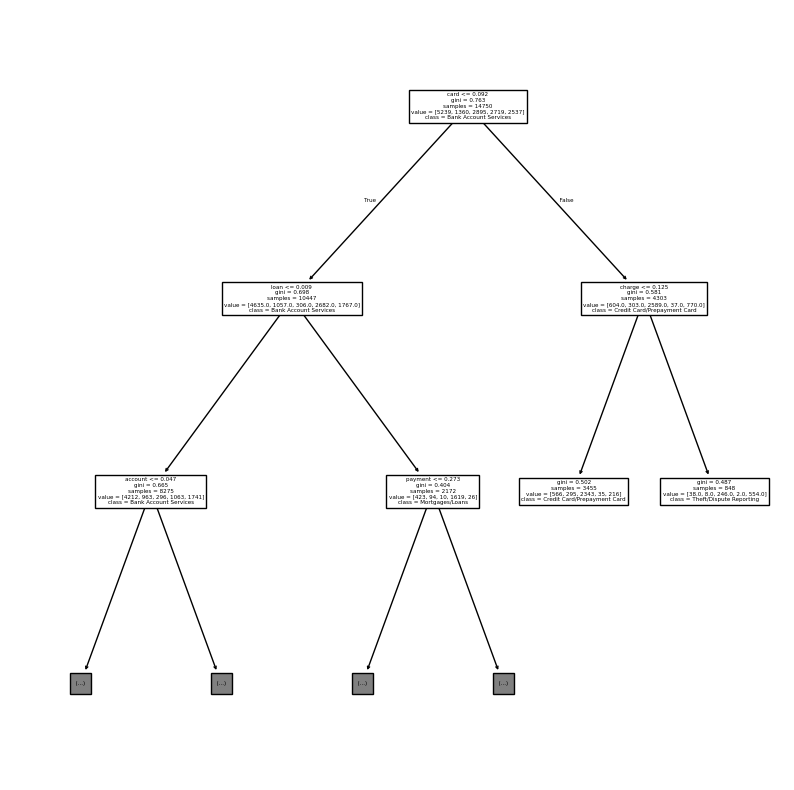

In [183]:
pyplot.figure(figsize=(10,10))
plot_tree(dtc,max_depth=2,class_names=le.classes_,feature_names=feature_vectors.columns)
pyplot.show()

### Random Forest Classifier

In [184]:
from sklearn.ensemble import RandomForestClassifier


In [185]:
rfc=RandomForestClassifier(n_estimators=100,max_depth=25,min_samples_leaf=2,verbose=1,oob_score=True)

In [186]:
rfc.fit(X_train,y_train)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    7.0s


RandomForestClassifier(max_depth=25, min_samples_leaf=2, oob_score=True,
                       verbose=1)

In [187]:
rfc.oob_score_

0.8043389830508475

In [188]:
y_pred_test=rfc.predict(X_test)
print(confusion_matrix(y_test,y_pred_test))
print(classification_report(y_test,y_pred_test))

[[2157    2   47   59   11]
 [ 127  400   67   35    4]
 [ 195    4  971    5   61]
 [ 178    2    9  924    6]
 [ 334    3   72    3  646]]
              precision    recall  f1-score   support

           0       0.72      0.95      0.82      2276
           1       0.97      0.63      0.77       633
           2       0.83      0.79      0.81      1236
           3       0.90      0.83      0.86      1119
           4       0.89      0.61      0.72      1058

    accuracy                           0.81      6322
   macro avg       0.86      0.76      0.80      6322
weighted avg       0.83      0.81      0.80      6322



[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s


In [189]:
feature_vectors.columns[rfc.feature_importances_.argsort()[-15:][::-1]]

Index(['card', 'account', 'loan', 'credit', 'charge', 'payment', 'mortgage',
       'report', 'dispute', 'check', 'inquiry', 'home', 'money', 'fund',
       'bank'],
      dtype='object')

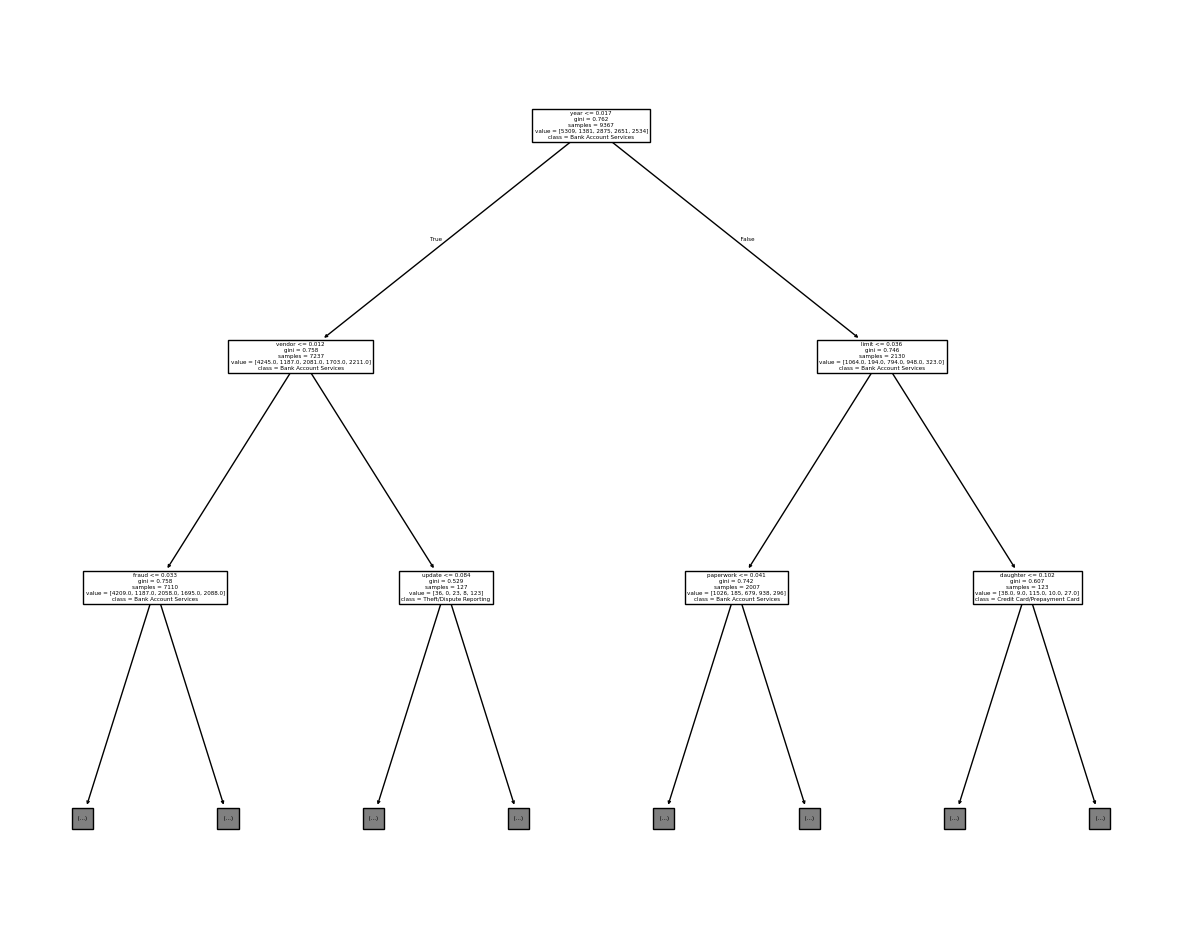

In [190]:
pyplot.figure(figsize=(15,12))
plot_tree(rfc.estimators_[90],max_depth=2,class_names=le.classes_,feature_names=feature_vectors.columns)
pyplot.show()

### Naive Bayes Classification

In [191]:
from sklearn.naive_bayes import GaussianNB,MultinomialNB

In [192]:
nbc = MultinomialNB()

In [193]:
nbc.fit(X_train,y_train)

MultinomialNB()

In [194]:
y_pred=nbc.predict(X_train)
print(confusion_matrix(y_train,y_pred))
print(classification_report(y_train,y_pred))

[[4921   14   96  177   31]
 [ 338  777  147   64   34]
 [ 700   19 1949   27  200]
 [ 473   11   41 2185    9]
 [ 736    4  103   22 1672]]
              precision    recall  f1-score   support

           0       0.69      0.94      0.79      5239
           1       0.94      0.57      0.71      1360
           2       0.83      0.67      0.75      2895
           3       0.88      0.80      0.84      2719
           4       0.86      0.66      0.75      2537

    accuracy                           0.78     14750
   macro avg       0.84      0.73      0.77     14750
weighted avg       0.80      0.78      0.78     14750



In [195]:
y_pred_test=nbc.predict(X_test)
print(confusion_matrix(y_test,y_pred_test))
print(classification_report(y_test,y_pred_test))

[[2135    9   44   70   18]
 [ 180  335   78   31    9]
 [ 412    7  710   14   93]
 [ 197    7   11  897    7]
 [ 351    7   47    5  648]]
              precision    recall  f1-score   support

           0       0.65      0.94      0.77      2276
           1       0.92      0.53      0.67       633
           2       0.80      0.57      0.67      1236
           3       0.88      0.80      0.84      1119
           4       0.84      0.61      0.71      1058

    accuracy                           0.75      6322
   macro avg       0.82      0.69      0.73      6322
weighted avg       0.78      0.75      0.74      6322



In [198]:

features=[]
for i in range(nbc.feature_count_.shape[0]):
  features.append(feature_vectors.columns[nbc.feature_count_[i].argsort()[-15:][::-1]])
features_nbc=pd.DataFrame(features,columns=range(15),index=le.classes_)

In [199]:
features_nbc

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Bank Account Services,account,payment,chase,check,money,bank,fund,day,fee,deposit,time,balance,credit,branch,number
Cibil Queries,credit,report,inquiry,account,chase,information,company,card,debt,reporting,identity,theft,letter,score,bureau
Credit Card/Prepayment Card,card,credit,chase,account,balance,fee,time,year,month,purchase,point,service,customer,bank,company
Mortgages/Loans,loan,mortgage,chase,home,modification,payment,property,year,time,letter,foreclosure,rate,document,debt,sale
Theft/Dispute Reporting,charge,chase,dispute,transaction,card,merchant,claim,account,credit,fee,fraud,time,service,day,bank
